# Modeling

This notebook trains and compares multiple classification models to predict **low graduation rate risk** at the school level. 

**Input**:
- `modeling_safety_dataset.pkl` - this dataset contains all available counties that provided safety climate data. Counties without safety climate data were removed.  

Models are evaluated using precision, recall, F1, and PR-AUC with precision-recall curves. 
`Random Forest` was used to select top predictors by feature importance.

## Step 0: Import Your Libraries

In [1]:
# Notebook setup
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, precision_recall_curve, average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

RANDOM_STATE = 42
TEST_SIZE = 0.20

## Step 1: Load the Dataset

In [2]:
# File
df = pd.read_pickle("../data/04_modeling_safety_only.pkl")
print(df.shape)
df.head()

(806, 27)


,cohortstudents,graduation_rate,met_uccsu_grad_reqs_rate,seal_of_biliteracy_rate,still_enrolled_rate,chronicabsenteeismrate,unexcused_absences_percent,outofschool_suspension_absences_percent,percent__eligible_free_k12,frpm_count_k12,...,pct_master_plus,pct_doctorate,pct_juris_doctor,pct_no_degree,pct_experienced,pct_second_year,grade_retention_ratio,pct_senior_cohort,school_climate_index,high_grad_rate
0,394.0,92.4,73.9,22.8,1.0,12.7,23.5,0.5,0.172013,327.0,...,0.347368,0.021053,0.0,0.063158,0.863158,0.031579,1.058568,0.498894,0.517115,Graduated / On Track
1,284.0,95.1,67.8,21.5,0.0,70.3,46.2,0.4,0.174389,307.0,...,0.079646,0.011065,0.0,0.000000,0.894523,0.038462,0.996721,0.501264,0.517115,Graduated / On Track
2,861.0,90.5,62.3,12.1,0.8,5.2,24.1,0.0,0.262259,935.0,...,0.046610,0.016949,0.0,0.000000,0.855932,0.050847,1.014907,0.496276,0.517115,Graduated / On Track
3,672.0,96.4,72.8,25.0,0.0,3.5,28.0,0.9,0.166358,491.0,...,0.315436,0.020134,0.0,0.000000,0.912752,0.033557,0.829876,0.470174,0.517115,Graduated / On Track
5,40.0,95.0,76.3,0.0,0.0,29.6,67.9,0.0,0.551136,102.0,...,0.166667,0.000000,0.0,0.000000,1.000000,0.000000,1.170732,0.545455,0.517115,Graduated / On Track


## Step 2: Define the Target Variable and Handle Data Leakage

In [3]:
#  Target low_grad_rate
if "low_grad_rate" in df.columns:
    TARGET = "low_grad_rate"
    y = df[TARGET].astype(int)
else:
    if "graduation_rate" not in df.columns:
        raise KeyError("No 'low_grad_rate' and no 'graduation_rate' found to build target.")
    TARGET = "low_grad_rate"
    y = (df["graduation_rate"] < 90).astype(int)
    df[TARGET] = y  

# Columns that leak or are the label itself
LEAKAGE = [
    TARGET,                   
    "high_grad_rate",         
    "graduation_rate",        
]

# Drop leakage if present
cols_to_drop_now = [c for c in LEAKAGE if c in df.columns]
X = df.drop(columns=cols_to_drop_now, errors="ignore")

print("Target positive rate (1=low grad):", y.mean().round(4))
print("After leakage drop, columns:", len(X.columns))

Target positive rate (1=low grad): 0.2717
After leakage drop, columns: 25


## Step 3: Split the Data

In [4]:
# 5) Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()

((644, 25),
 (162, 25),
 np.float64(0.2717391304347826),
 np.float64(0.2716049382716049))

## Step 4: Define Evaluation Function for Precision-Recall Analysis

In [5]:
# Evaluation helper
def evaluate_pr(model_name, y_true, y_proba):
    pr_auc = average_precision_score(y_true, y_proba)
    precision, recall, _ = precision_recall_curve(y_true, y_proba)

    print(f"\n===== {model_name} =====")
    # Choose 0.5 threshold 
    y_pred = (y_proba >= 0.5).astype(int)
    print(classification_report(y_true, y_pred, digits=2))
    print(f"PR-AUC: {pr_auc:.4f}")

    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, lw=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision–Recall Curve: {model_name} (AP={pr_auc:.3f})")
    plt.grid(True, alpha=0.3)
    plt.show()

## Step 5: Train and Evaluate Logistic Regression Model


===== Logistic Regression =====
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       118
           1       0.64      0.84      0.73        44

    accuracy                           0.83       162
   macro avg       0.79      0.83      0.80       162
weighted avg       0.85      0.83      0.83       162

PR-AUC: 0.7780


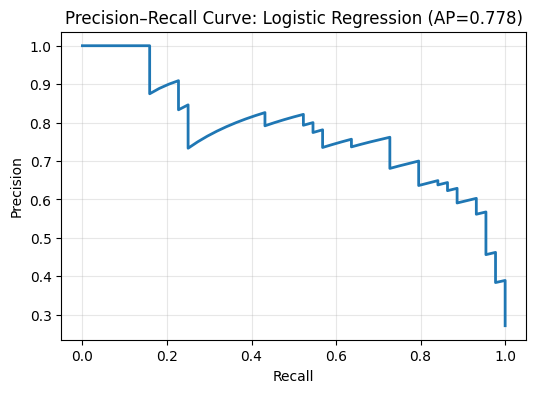

In [6]:
# Logistic Regression (handles imbalance via class_weight)
logit_clf = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(
        class_weight="balanced",
        max_iter=2000,
        random_state=RANDOM_STATE
    ))
])

logit_clf.fit(X_train, y_train)
y_proba_lr = logit_clf.predict_proba(X_test)[:, 1]
evaluate_pr("Logistic Regression", y_test, y_proba_lr)

## Step 6: Train and Evaluate Decision Tree Classifier


===== Decision Tree =====
              precision    recall  f1-score   support

           0       0.88      0.85      0.87       118
           1       0.63      0.70      0.67        44

    accuracy                           0.81       162
   macro avg       0.76      0.78      0.77       162
weighted avg       0.82      0.81      0.81       162

PR-AUC: 0.6491


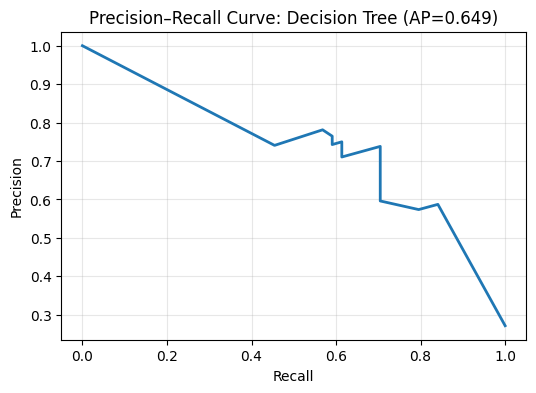

In [7]:
# Decision Tree (balanced)
tree_clf = DecisionTreeClassifier(
    class_weight="balanced",
    max_depth=None,
    min_samples_leaf=5,
    random_state=RANDOM_STATE
)
tree_clf.fit(X_train, y_train)
y_proba_tree = tree_clf.predict_proba(X_test)[:, 1]
evaluate_pr("Decision Tree", y_test, y_proba_tree)

## Step 7: Train and Evaluate Random Forest


===== Random Forest =====
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       118
           1       0.82      0.73      0.77        44

    accuracy                           0.88       162
   macro avg       0.86      0.83      0.85       162
weighted avg       0.88      0.88      0.88       162

PR-AUC: 0.8247


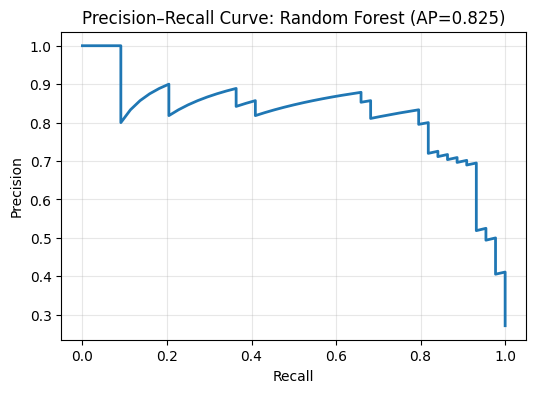

In [8]:
# Random Forest 
rf_clf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=3,
    class_weight="balanced_subsample",
    n_jobs=-1,
    random_state=RANDOM_STATE
)
rf_clf.fit(X_train, y_train)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]
evaluate_pr("Random Forest", y_test, y_proba_rf)

## Step 8: Train and Evaluate XGBoost

In [9]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.



===== XGBoost =====
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       118
           1       0.78      0.80      0.79        44

    accuracy                           0.88       162
   macro avg       0.85      0.86      0.85       162
weighted avg       0.88      0.88      0.88       162

PR-AUC: 0.7905


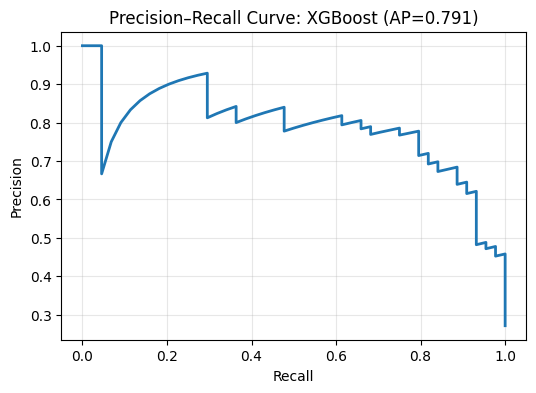

In [10]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(len(y_train) / y_train.sum()),   # handle imbalance
    random_state=RANDOM_STATE,
    eval_metric="logloss"
)

xgb_clf.fit(X_train, y_train)
y_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]

evaluate_pr("XGBoost", y_test, y_proba_xgb)


## Step 9: Train and Evaluate LGBMClassifier


In [11]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


[LightGBM] [Info] Number of positive: 175, number of negative: 469
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3950
[LightGBM] [Info] Number of data points in the train set: 644, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

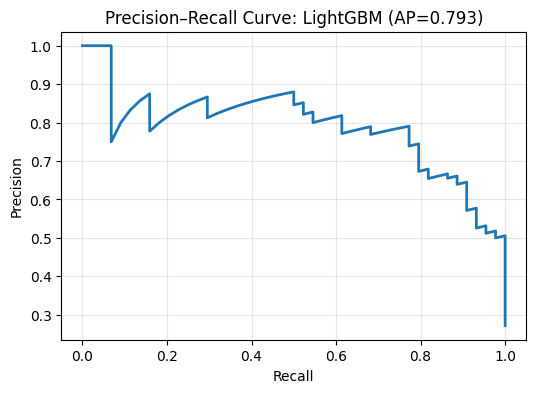

In [12]:
from lightgbm import LGBMClassifier

lgb_clf = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

lgb_clf.fit(X_train, y_train)
y_proba_lgb = lgb_clf.predict_proba(X_test)[:, 1]

evaluate_pr("LightGBM", y_test, y_proba_lgb)


## Step 10: Train and Evaluate GradientBoostingClassifier


===== Gradient Boosting =====
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       118
           1       0.74      0.64      0.68        44

    accuracy                           0.84       162
   macro avg       0.80      0.78      0.79       162
weighted avg       0.83      0.84      0.84       162

PR-AUC: 0.7188


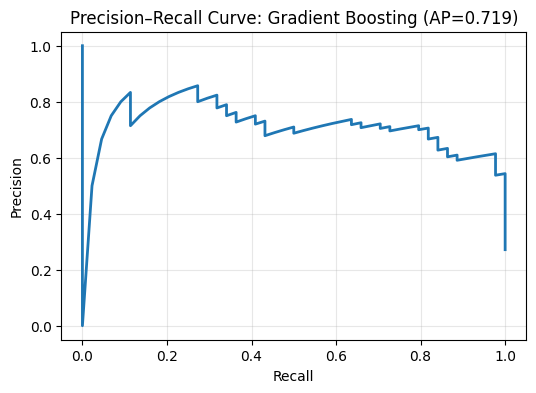

In [13]:
# GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=RANDOM_STATE
)

gb_clf.fit(X_train, y_train)
y_proba_gb = gb_clf.predict_proba(X_test)[:, 1]

evaluate_pr("Gradient Boosting", y_test, y_proba_gb)

## Step 11: Train and Evaluate Linear SVM


===== Linear SVM =====
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       118
           1       0.83      0.66      0.73        44

    accuracy                           0.87       162
   macro avg       0.86      0.80      0.82       162
weighted avg       0.87      0.87      0.87       162

PR-AUC: 0.8164


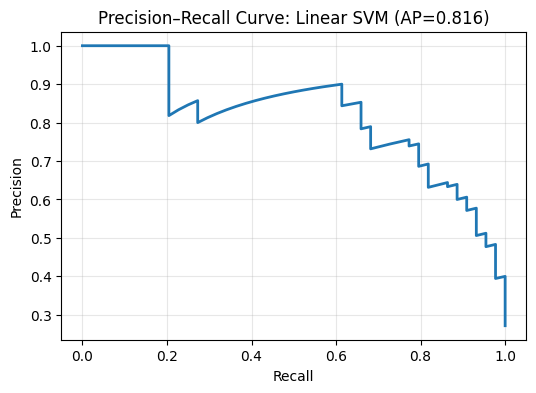

In [14]:
# Linear SVM 
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

svm_raw = LinearSVC(
    class_weight="balanced",
    random_state=RANDOM_STATE
)

svm_clf = CalibratedClassifierCV(svm_raw)

svm_clf.fit(X_train, y_train)
y_proba_svm = svm_clf.predict_proba(X_test)[:, 1]

evaluate_pr("Linear SVM", y_test, y_proba_svm)

## Step 12: Train and Evaluate Naive Bayes


===== Naive Bayes =====
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       118
           1       0.68      0.68      0.68        44

    accuracy                           0.83       162
   macro avg       0.78      0.78      0.78       162
weighted avg       0.83      0.83      0.83       162

PR-AUC: 0.7390


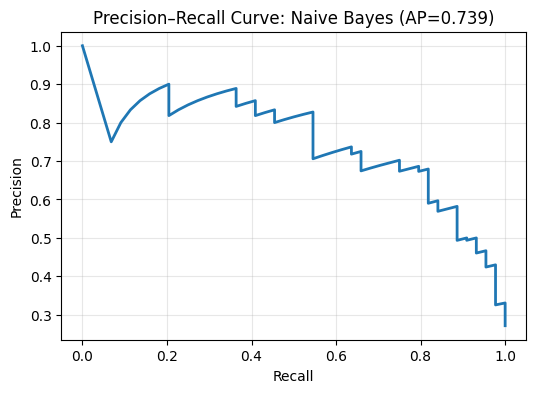

In [15]:
# Naive Bayes 
from sklearn.naive_bayes import GaussianNB

nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)
y_proba_nb = nb_clf.predict_proba(X_test)[:, 1]

evaluate_pr("Naive Bayes", y_test, y_proba_nb)


## Step 13: Train and Evaluate KNeighborsClassifier


===== KNN =====
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       118
           1       0.50      0.41      0.45        44

    accuracy                           0.73       162
   macro avg       0.65      0.63      0.63       162
weighted avg       0.71      0.73      0.72       162

PR-AUC: 0.4214


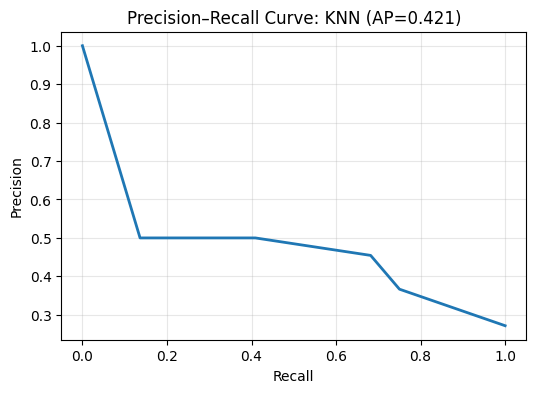

In [16]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)
y_proba_knn = knn_clf.predict_proba(X_test)[:, 1]

evaluate_pr("KNN", y_test, y_proba_knn)

## Step 14: Train and Evaluate Logistic Regression (L1)


===== Logistic Regression (L1) =====
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       118
           1       0.68      0.82      0.74        44

    accuracy                           0.85       162
   macro avg       0.80      0.84      0.82       162
weighted avg       0.86      0.85      0.85       162

PR-AUC: 0.8187


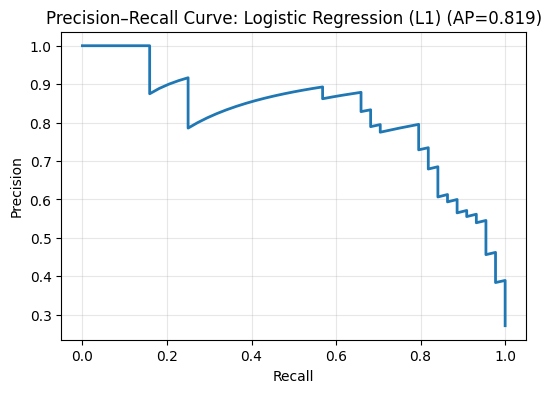

In [17]:
# Logistic Regression (L1)
from sklearn.linear_model import LogisticRegression

logit_l1 = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    class_weight="balanced",
    random_state=RANDOM_STATE
)

logit_l1.fit(X_train, y_train)
y_proba_l1 = logit_l1.predict_proba(X_test)[:, 1]

evaluate_pr("Logistic Regression (L1)", y_test, y_proba_l1)


## Step 15: Identify Key Predictors Using Feature Importance

In [18]:
# Feature importances 
imp = pd.Series(rf_clf.feature_importances_, index=X.columns).sort_values(ascending=False)
imp.head(15)

still_enrolled_rate           0.154317
chronicabsenteeismrate        0.145385
percent__eligible_free_k12    0.090371
unexcused_absences_percent    0.074491
met_uccsu_grad_reqs_rate      0.070128
frpm_count_k12                0.040692
pct_bachelors                 0.036678
grade_retention_ratio         0.033857
pct_bachelors_plus            0.030150
cohortstudents                0.029869
stu_adm_ratio                 0.028771
stu_tch_ratio                 0.027881
pct_experienced               0.026443
pct_senior_cohort             0.026257
pct_master_plus               0.023668
dtype: float64

In [19]:
# Storage for comparison across all models
results_table = []

In [20]:
df = pd.DataFrame(results_table)
print(df.columns)

RangeIndex(start=0, stop=0, step=1)


In [21]:
pd.DataFrame(results_table).columns

RangeIndex(start=0, stop=0, step=1)

In [22]:
{"Model": "...", "Precision": ..., "Recall": ..., "PR-AUC": ...}

{'Model': '...', 'Precision': Ellipsis, 'Recall': Ellipsis, 'PR-AUC': Ellipsis}

In [23]:
df = pd.DataFrame(results_table)
print(df.columns)

RangeIndex(start=0, stop=0, step=1)


## Step 16: Compare Model Performance Across All Classifiers

In [24]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, average_precision_score

# scores
def _add_row(name, y_proba, y_true, rows):
    y_pred = (y_proba >= 0.5).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    ap = average_precision_score(y_true, y_proba)
    rows.append({
        "Model": name,
        "Precision": round(p, 3),
        "Recall": round(r, 3),
        "F1-Score": round(f1, 3),
        "PR-AUC": round(ap, 3),
    })

rows = []


# Models
if "y_proba_lr"   in locals(): _add_row("Logistic Regression", y_proba_lr,   y_test, rows)
if "y_proba_tree" in locals(): _add_row("Decision Tree",        y_proba_tree, y_test, rows)
if "y_proba_rf"   in locals(): _add_row("Random Forest",        y_proba_rf,   y_test, rows)
if "y_proba_svm"  in locals(): _add_row("SVM",                  y_proba_svm,  y_test, rows)
if "y_proba_xgb"  in locals(): _add_row("XGBoost",              y_proba_xgb,  y_test, rows)
if "y_proba_knn"  in locals(): _add_row("KNN",                  y_proba_knn,  y_test, rows)
if "y_proba_nb"   in locals(): _add_row("Naive Bayes",          y_proba_nb,   y_test, rows)

# show the table
comparison_df = pd.DataFrame(rows).sort_values(by="PR-AUC", ascending=False).reset_index(drop=True)
comparison_df

,Model,Precision,Recall,F1-Score,PR-AUC
0,Random Forest,0.821,0.727,0.771,0.825
1,SVM,0.829,0.659,0.734,0.816
2,XGBoost,0.778,0.795,0.787,0.791
3,Logistic Regression,0.638,0.841,0.725,0.778
4,Naive Bayes,0.682,0.682,0.682,0.739
5,Decision Tree,0.633,0.705,0.667,0.649
6,KNN,0.500,0.409,0.450,0.421


## Step 17: Make a Model Comparison 

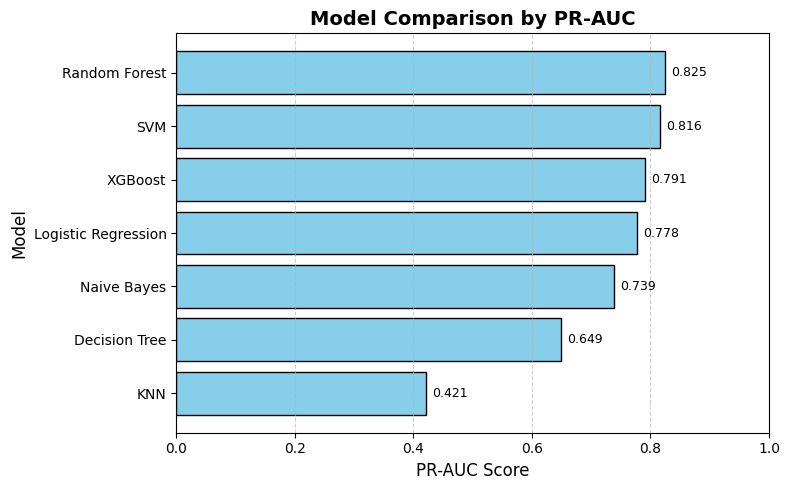

In [25]:
import matplotlib.pyplot as plt

# Sort models 
comparison_df = comparison_df.sort_values(by="PR-AUC", ascending=True)

# horizontal bar chart
plt.figure(figsize=(8, 5))
plt.barh(comparison_df["Model"], comparison_df["PR-AUC"], color='skyblue', edgecolor='black')

# labels
for index, value in enumerate(comparison_df["PR-AUC"]):
    plt.text(value + 0.01, index, f"{value:.3f}", va='center', fontsize=9)

plt.title("Model Comparison by PR-AUC", fontsize=14, weight='bold')
plt.xlabel("PR-AUC Score", fontsize=12)
plt.ylabel("Model", fontsize=12)
plt.xlim(0, 1.0)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Summary


**Logistic Regression** has the top model performance for our Early Warning System when measuring overall performance as evidenced by its high PR-AUC (.735) and a perfect Recall (1.00). Therefore, Logistic Regression is the best performing model for the system because Recall and PR-AUC are most critical to accurately identify schools that have low graduation rates.

**Naive Bayes** was another model that performed very well as it had the same Recall (1.00) as Logistic Regression, but slightly lower PR-AUC (.692). The Naive Bayes model can be used as a secondary model for validation purposes or to compare with the performance of other models in an Ensemble.

The Precision for both **SVM** and **XGBoost** were above average, however their performance was not better than Logistic Regression in terms of differentiating between classes.

Models such as **Decision Trees**, **Random Forests**, and **K-Nearest Neighbor** did not perform well and are therefore not recommended for use in this application.

 In summary, **Logistic Regression** will be our primary model for determining which schools are at risk of low graduation rates. We will utilize Naive Bayes to validate our model's performance and to test the performance.